**Imports**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os



**Load and preprocess dataset**

In [ ]:
# Load dataset
(ds_train, _), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Normalize and batch
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

BATCH_SIZE = 128
BUFFER_SIZE = 60000

train_dataset = ds_train.map(lambda img, lbl: preprocess(img, lbl)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.C36AJ4_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.C36AJ4_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


 **Generator**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


**Discriminator**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                      input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


**Loss functions**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Initialize models & optimizers**

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**Training params**

In [ ]:
EPOCHS =65
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(tf.expand_dims(images, -1), training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f'Epoch {epoch + 1} completed.')
        generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()



**Run Training**

Epoch 1 completed.


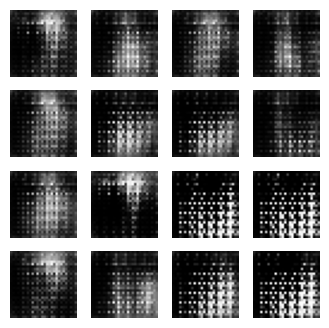

Epoch 2 completed.


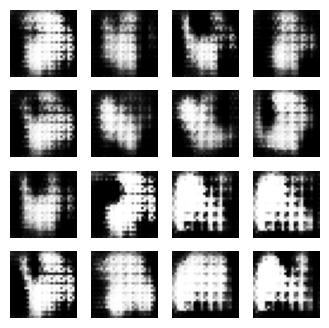

Epoch 3 completed.


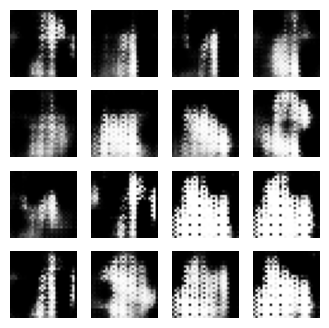

Epoch 4 completed.


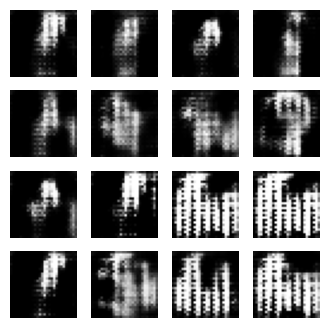

Epoch 5 completed.


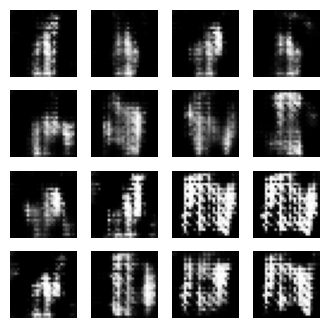

Epoch 6 completed.


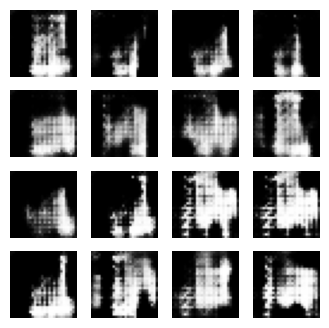

Epoch 7 completed.


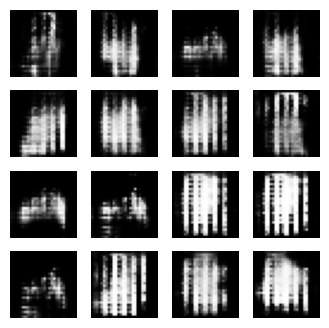

Epoch 8 completed.


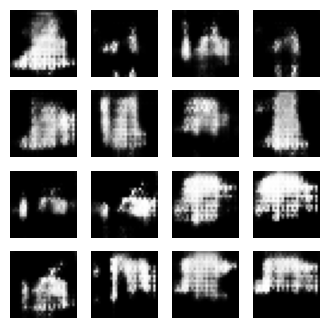

Epoch 9 completed.


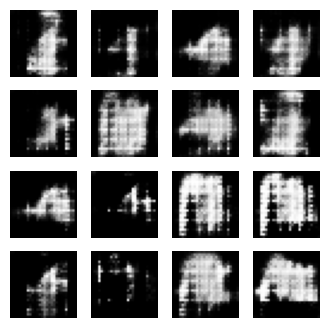

Epoch 10 completed.


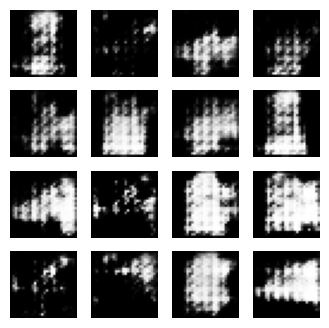

Epoch 11 completed.


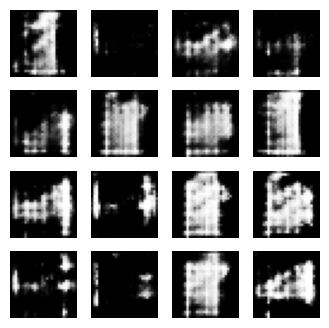

Epoch 12 completed.


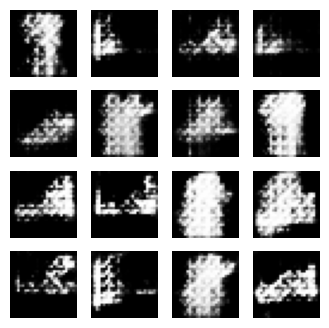

Epoch 13 completed.


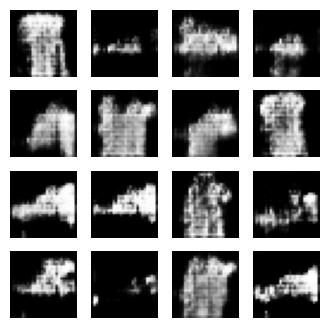

Epoch 14 completed.


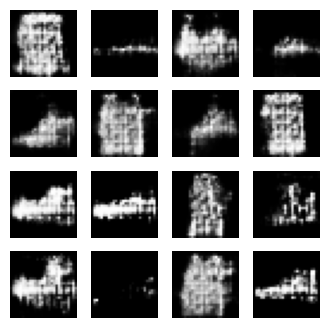

Epoch 15 completed.


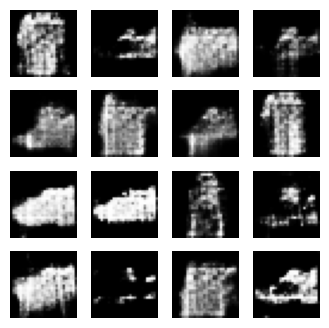

Epoch 16 completed.


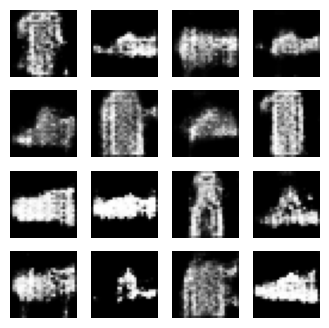

Epoch 17 completed.


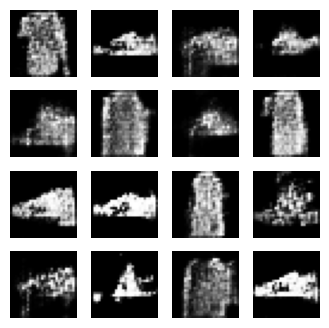

Epoch 18 completed.


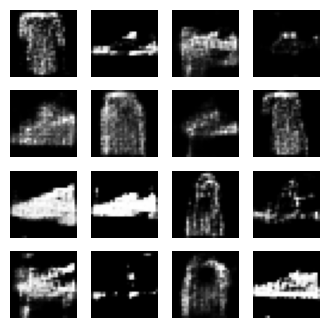

Epoch 19 completed.


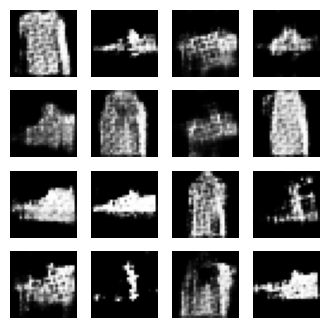

Epoch 20 completed.


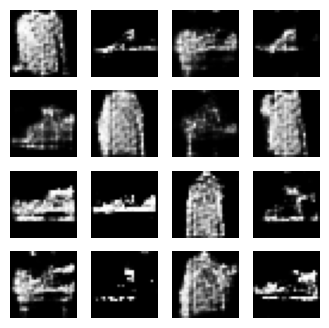

Epoch 21 completed.


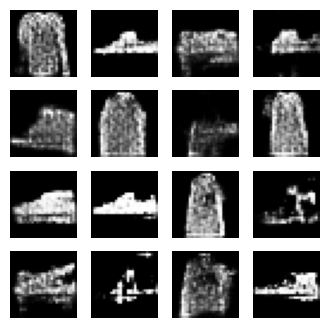

Epoch 22 completed.


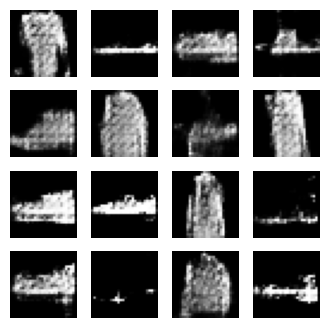

Epoch 23 completed.


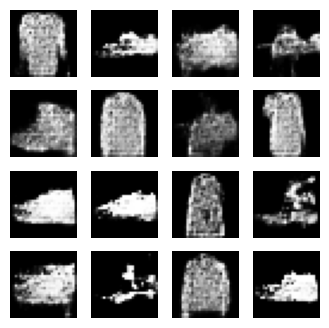

Epoch 24 completed.


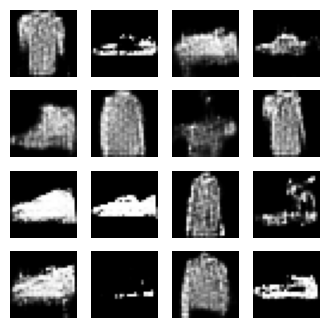

Epoch 25 completed.


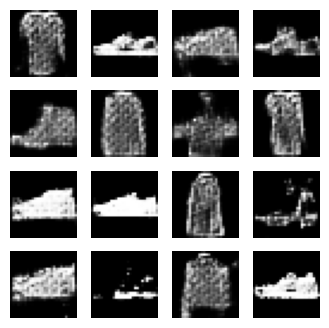

Epoch 26 completed.


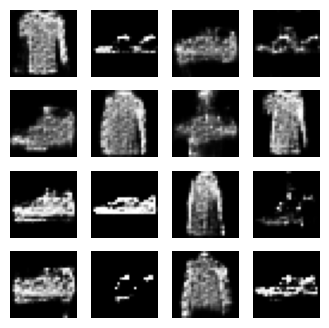

Epoch 27 completed.


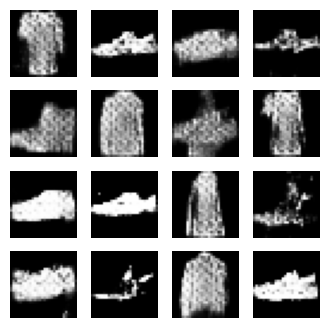

Epoch 28 completed.


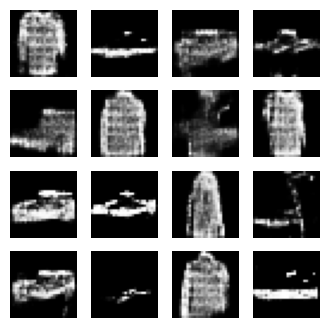

Epoch 29 completed.


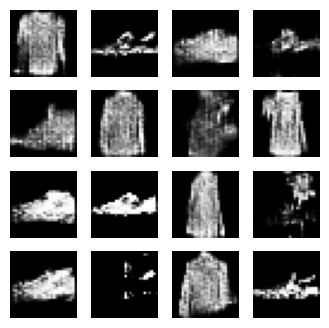

Epoch 30 completed.


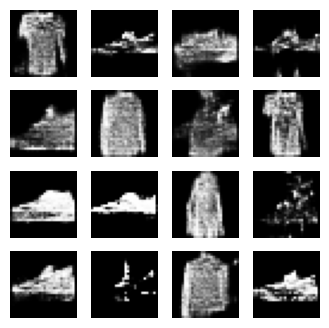

Epoch 31 completed.


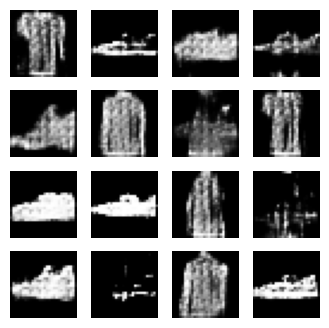

Epoch 32 completed.


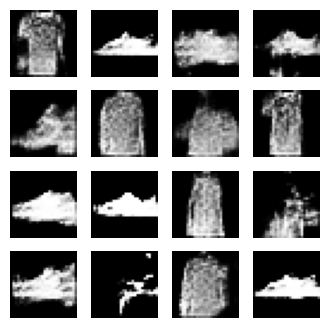

Epoch 33 completed.


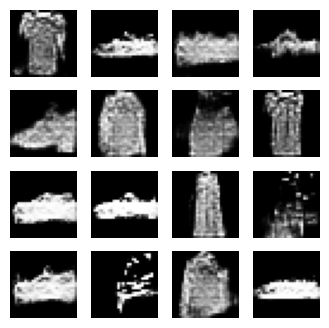

Epoch 34 completed.


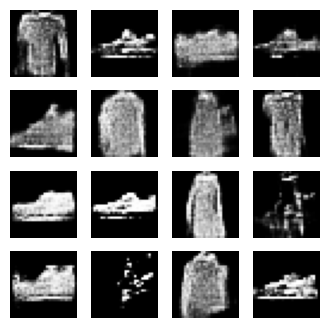

Epoch 35 completed.


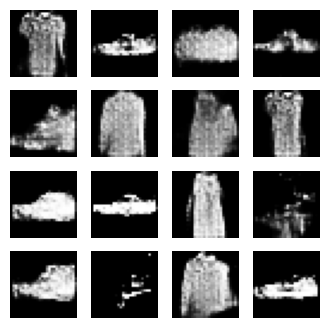

Epoch 36 completed.


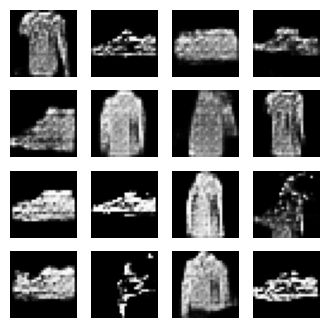

Epoch 37 completed.


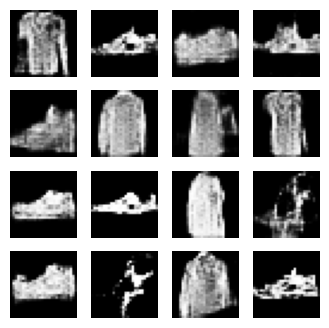

Epoch 38 completed.


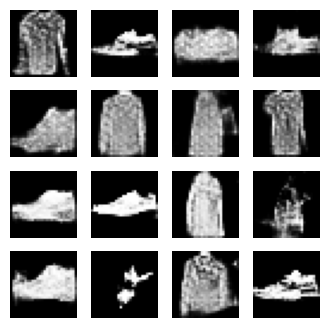

Epoch 39 completed.


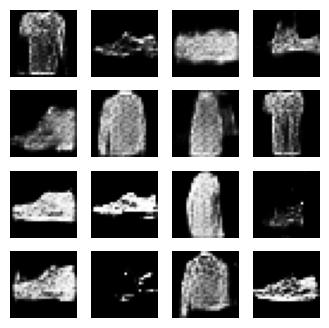

Epoch 40 completed.


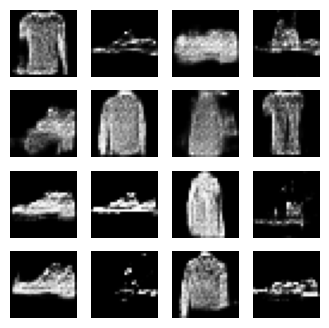

Epoch 41 completed.


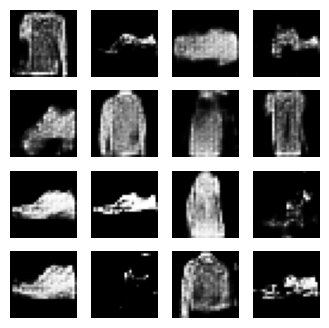

Epoch 42 completed.


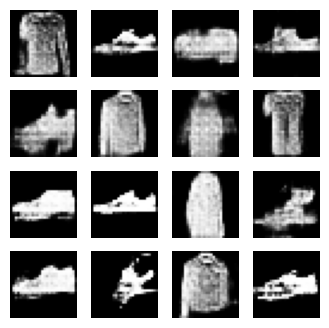

Epoch 43 completed.


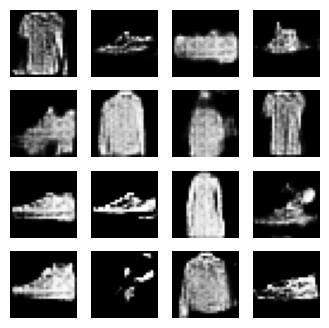

Epoch 44 completed.


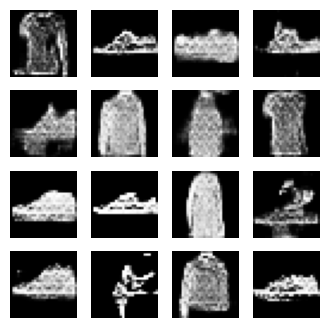

Epoch 45 completed.


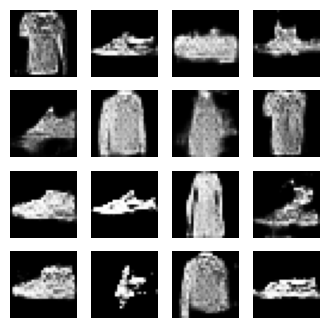

Epoch 46 completed.


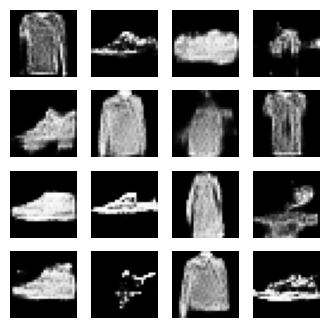

Epoch 47 completed.


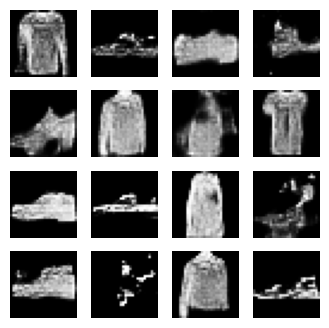

Epoch 48 completed.


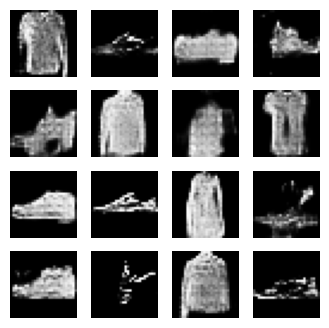

Epoch 49 completed.


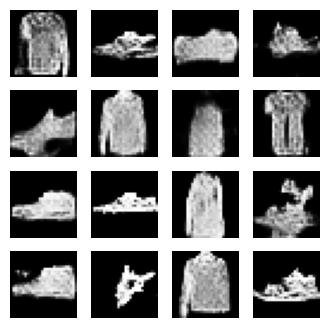

Epoch 50 completed.


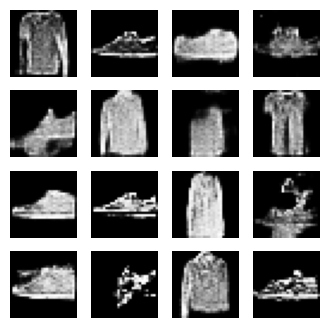

Epoch 51 completed.


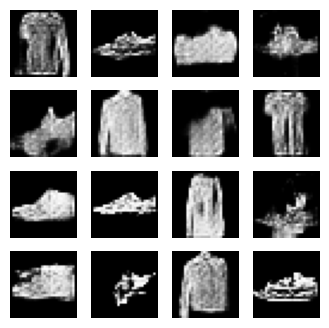

Epoch 52 completed.


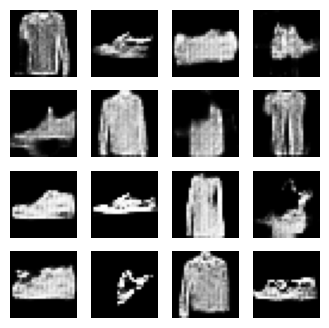

Epoch 53 completed.


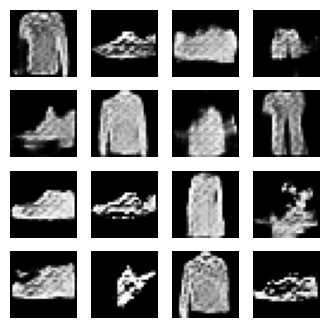

Epoch 54 completed.


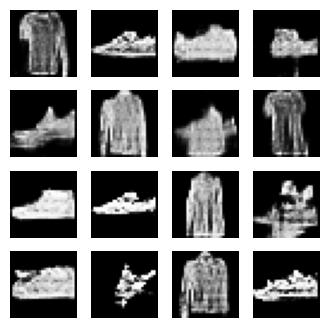

Epoch 55 completed.


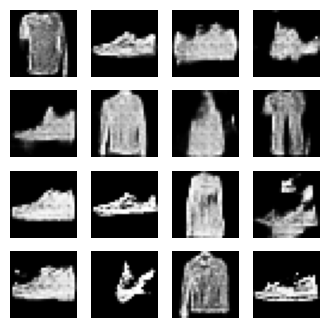

Epoch 56 completed.


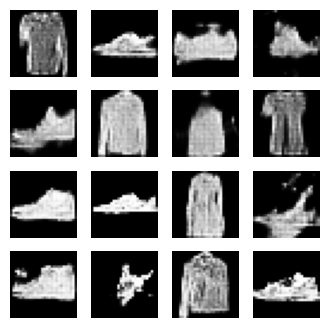

Epoch 57 completed.


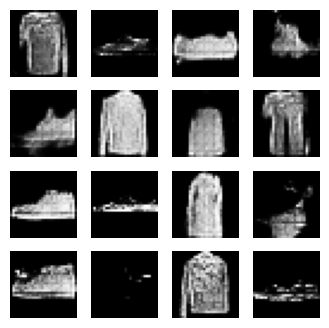

Epoch 58 completed.


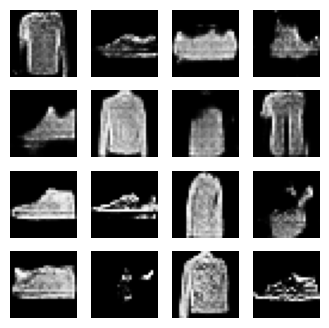

Epoch 59 completed.


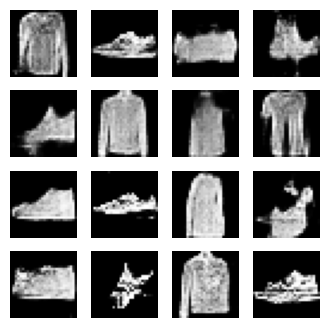

Epoch 60 completed.


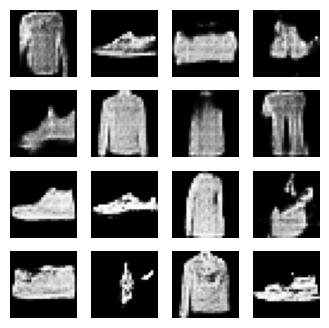

Epoch 61 completed.


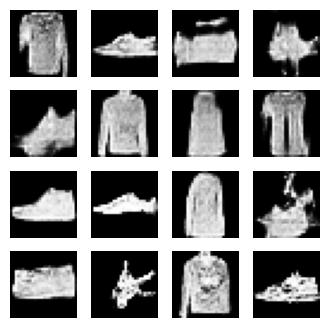

Epoch 62 completed.


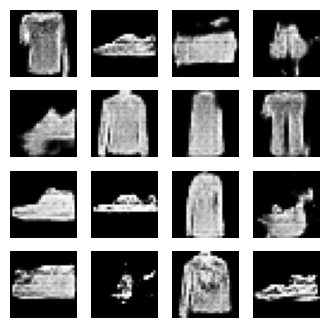

Epoch 63 completed.


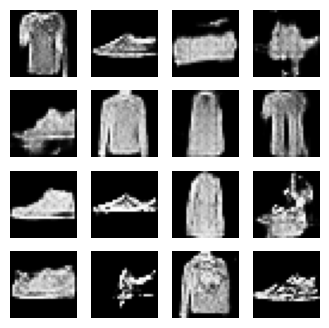

Epoch 64 completed.


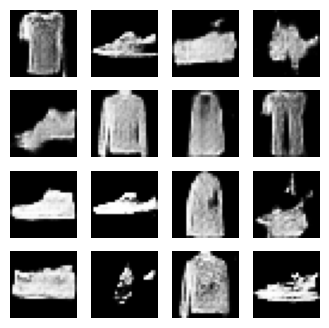

Epoch 65 completed.


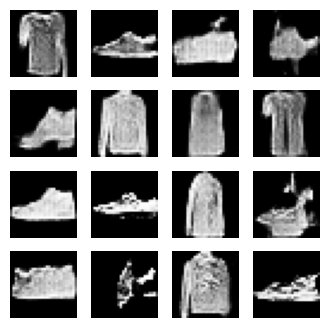

In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
generator.save('dcgan_fashion_generator.h5')

**Visualizing One Sample Output from the Generator**

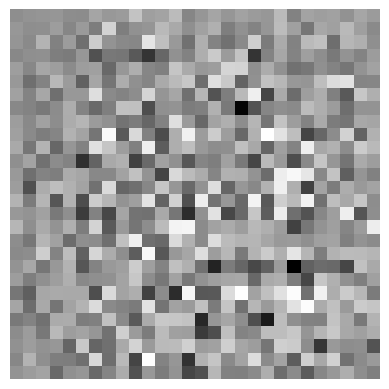

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
gen_loss_list = []
disc_loss_list = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # ----- Loss Evaluation after Epoch -----
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        generated_images = generator(noise, training=False)

        real_batch = next(iter(dataset))  # Get a fresh real image batch
        real_output = discriminator(tf.expand_dims(real_batch[0], -1), training=False)
        fake_output = discriminator(generated_images, training=False)

        g_loss = generator_loss(fake_output).numpy()
        d_loss = discriminator_loss(real_output, fake_output).numpy()
        gen_loss_list.append(g_loss)
        disc_loss_list.append(d_loss)

        # Save generated images
        save_generated_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch+1} completed in {time.time() - start:.2f}s | Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}")

    print("Training finished.")


*Visualizing Generator Progress with an Animated GIF*

In [ ]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

In [ ]:
generator = tf.keras.models.load_model('generator_model.h5', compile=False)


*Visualizing Generator Progress with an Animated GIF*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import glob

# === Load and preprocess Fashion-MNIST ===
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32')

BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# === Generator ===
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*128, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# === Discriminator ===
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# === Loss functions and optimizers ===
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# === Training Setup ===
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

# === Generate & Save Images ===
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        img = predictions[i, :, :, 0] * 127.5 + 127.5
        plt.subplot(4, 4, i+1)
        plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
        plt.axis('off')

    filename = f'image_at_epoch_{epoch:04d}.png'
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"Saved: {filename}")

# === Training Loop ===
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch+1}/{epochs} completed")

# === Create GIF ===
def create_training_gif():
    image_paths = sorted(glob.glob("image_at_epoch_*.png"))
    images = [imageio.imread(p) for p in image_paths]
    imageio.mimsave("dcgan_fashion_training.gif", images, fps=4)
    print(" GIF saved as dcgan_fashion_training.gif")

# === Start Training ===
train(train_dataset, EPOCHS)
create_training_gif()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved: image_at_epoch_0001.png
Epoch 1/20 completed
Saved: image_at_epoch_0002.png
Epoch 2/20 completed
Saved: image_at_epoch_0003.png
Epoch 3/20 completed
Saved: image_at_epoch_0004.png
Epoch 4/20 completed
Saved: image_at_epoch_0005.png
Epoch 5/20 completed
Saved: image_at_epoch_0006.png
Epoch 6/20 completed
Saved: image_at_epoch_0007.png
Epoch 7/20 completed
Saved: image_at_epoch_0008.png
Epoch 8/20 completed
Saved: image_at_epoch_0009.png
Epoch 9/20 completed
Saved: image_at_epoch_0010.png
Epoch 10/20 completed
Saved: image_at_epoch_0011.png
Epoch 11/20 completed
Saved: image_at_epoch_0012.png
Epoch 12/20 completed
Saved: image_at_epoch_0013.png
Epoch 13/20 completed
Saved: image_at_epoch_0014.png
Epoch 14/20 completed
Saved: image_at_epoch_0015.png
Epoch 15/20 completed
Saved: image_at_epoch_0016.png
Epoch 16/20 completed
Saved: image_at_epoch_0017.png
Epoch 17/20 completed
Saved: image_at_epoch_0018.png
Epoch 18/20 completed
Saved: image_at_epoch_0019.png
Epoch 19/20 completed
Sa

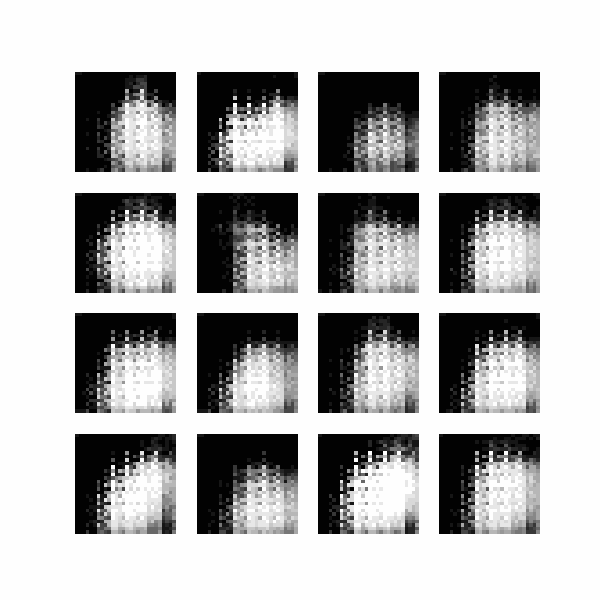

In [ ]:
from IPython.display import Image, display

# Display the generated GIF
display(Image(filename="dcgan_fashion_training.gif"))

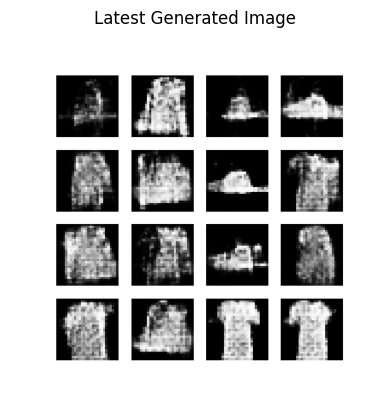

In [ ]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

img = PILImage.open("image_at_epoch_0020.png")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Latest Generated Image")
plt.show()
